<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/dev/VesuviusChallenge/VesuviusChallenge_nb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VesuviusChallenge - Deciphering Ancient Papyrus Scrolls

## Download data

In [1]:
### Download data from kaggle, and store a segment of it in google drive

# import json
# import zipfile
# kaggle_apikey = {"username":"jamesdavey","key":"a8975caa44cfa08d6f2164f2d5977b6e"}

# if not os.path.exists('/root/.kaggle'): os.mkdir('/root/.kaggle')
# with open('/root/.kaggle/kaggle.json', 'w') as f:
#     json.dump(kaggle_apikey, f)

# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c 'vesuvius-challenge-ink-detection' --force
# # #1% 131M/20.6G [00:06<17:23, 21.1MB/s]

# with zipfile.ZipFile("/content/vesuvius-challenge-ink-detection.zip","r") as zip_ref:
#     zip_ref.extractall("kaggledata")

# !zip -r -j /content/ink1.zip /content/content/kaggledata/train/1

# # upload zip to google drive
# from google.colab import drive
# drive.mount('/content/gdrive')
# !cp /content/ink1.zip /content/gdrive/MyDrive/AIData/vesuvius1.zip

In [2]:
## Retrieve data(zip) from google drive
from google.colab import drive
drive.mount('/content/gdrive')
!cp /content/gdrive/MyDrive/AIData/vesuvius1.zip /content/vesuvius1.zip 

Mounted at /content/gdrive


In [3]:
import zipfile
with zipfile.ZipFile("vesuvius1.zip","r") as zip_ref:
    zip_ref.extractall("train_data")
drive.flush_and_unmount()

## Imports

In [4]:
import torch
import torch.nn as nn
import numpy as np
import PIL
# import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from pathlib import Path
import os
import time

try:
    import einops
except:
    print(f"einops not installed as required, installing...")
    !pip3 install einops

from einops import rearrange, reduce, repeat

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"on device: {device}")

einops not installed as required, installing...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.0 MB/s eta 0:00:00
on device: cuda


## Understanding the data

In [5]:
root_filepath = '/content/train_data/'

all_files = sorted(os.listdir(root_filepath))
# ['inklabels.png', 'inklabels_rle.csv', 'ir.png', 'mask.png']
tif_filenames = all_files[:-4]
print(len(tif_filenames))

65


In [6]:
import pandas as pd
df = pd.read_csv(root_filepath+'inklabels_rle.csv')
print(len(df.Predicted[0]))
df.head()

348148


,Id,Predicted
0,1,606211 19 612538 26 618867 39 625196 44 631525...


img_original shape: (8181, 6330)
img_ink_labels shape: (8181, 6330)
img_ink_mask shape: (8181, 6330)


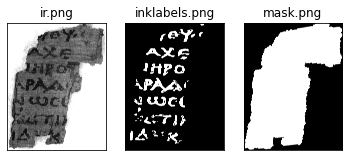

In [7]:
img_original = np.array(PIL.Image.open(root_filepath+'ir.png'))
img_ink_labels = np.array(PIL.Image.open(root_filepath+'inklabels.png'))
img_ink_mask = np.array(PIL.Image.open(root_filepath+'mask.png'))
print(f"img_original shape: {img_original.shape}")
print(f"img_ink_labels shape: {img_ink_labels.shape}")
print(f"img_ink_mask shape: {img_ink_mask.shape}")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.set_title('ir.png')
ax1.imshow(img_original, cmap = 'gray')
ax2.set_title('inklabels.png')
ax2.imshow(img_ink_labels, cmap = 'gray')
ax3.set_title('mask.png')
ax3.imshow(img_ink_mask, cmap = 'gray')
for ax in [ax1, ax2, ax3]:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

[0.0, 0.69755095, 0.8771649, 0.855787]


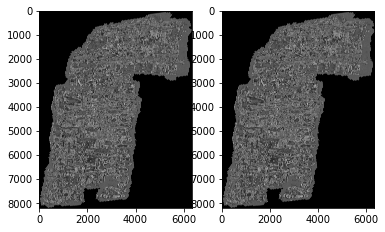

In [8]:
#Each tif file is a layer in the scan
images = []
for path in tif_filenames[:2]:
    images.append(np.array(PIL.Image.open(root_filepath+path), dtype = np.float32)/65535.0)
print([images[0][i].max() for i in range(0, 2000, 500)])

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(images[0], cmap = 'gray')
ax2.imshow(images[1], cmap = 'gray')
plt.show()

In [9]:
del img_original
del img_ink_labels
del img_ink_mask
del images

# Creating dataset

In [10]:
root_filepath = '/content/train_data/'
all_files = sorted(os.listdir(root_filepath)) # [... '64.tif', 'inklabels.png', 'inklabels_rle.csv', 'ir.png', 'mask.png']
tif_filenames = all_files[:-4]

### Hyperparameters
dist_from_centre = 30
Z_START = 27 # First slice in the z direction to use
Z_DIM = 10   # Number of slices in the z direction
test_rectangle = (1100, 3500, 700, 950)

In [11]:
mask = torch.from_numpy(np.array(PIL.Image.open(root_filepath+"mask.png").convert('1')))
label = torch.from_numpy(np.array(PIL.Image.open(root_filepath+"inklabels.png"))).float().to(device)
# plt.imshow(img.cpu(), cmap = 'gray')

In [12]:
layers_to_use = tif_filenames[Z_START:Z_START+Z_DIM]
images = [np.array(PIL.Image.open(root_filepath+filename), dtype=np.float32)/65535.0 for filename in tqdm(layers_to_use)]
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(device)
print(f"image_stack shape: {image_stack.shape}")

100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


image_stack shape: torch.Size([10, 8181, 6330])


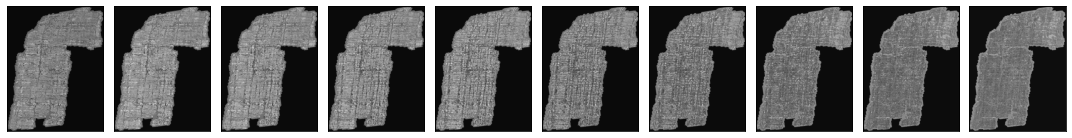

In [13]:
fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
for image, ax in zip(images, axes):
  ax.imshow(np.array(PIL.Image.fromarray(image).resize((image.shape[1]//20, image.shape[0]//20)), dtype=np.float32), cmap='gray')
  ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

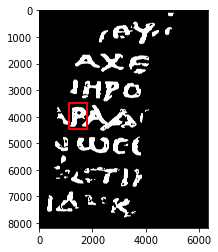

In [14]:
fig, ax = plt.subplots()
ax.imshow(label.cpu(), cmap = 'gray')
patch = matplotlib.patches.Rectangle((test_rectangle[0], test_rectangle[1]), test_rectangle[2], test_rectangle[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

In [15]:
print("Generating pixel lists...")
# Split our dataset into train and val. The pixels inside the rect are the 
# val set, and the pixels outside the rect are the train set.
def generate_pixels_lists(rect, buffer = dist_from_centre):
  t1 = time.time()
  pixels_inside_rect = []
  pixels_outside_rect = []
  for pixel in zip(*np.where(mask == 1)):
      if pixel[1] < buffer or pixel[1] >= mask.shape[1]-buffer or pixel[0] < buffer or pixel[0] >= mask.shape[0]-buffer:
          continue # Too close to the edge
      if pixel[1] >= rect[0] and pixel[1] <= rect[0]+rect[2] and pixel[0] >= rect[1] and pixel[0] <= rect[1]+rect[3]:
          pixels_inside_rect.append(pixel)
      else:
          pixels_outside_rect.append(pixel)
  print(f"pixels inside: {len(pixels_inside_rect)} | pixels_outside: {len(pixels_outside_rect)} | Time taken: {time.time()-t1:.2f}")

  return pixels_inside_rect, pixels_outside_rect

pixels_inside_rect, pixels_outside_rect = generate_pixels_lists(test_rectangle)

Generating pixel lists...
pixels inside: 666651 | pixels_outside: 28470276 | Time taken: 53.27


In [16]:
class SubvolumeDataset(torch.utils.data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = rearrange(self.image_stack[:, y-dist_from_centre:y+dist_from_centre+1, x-dist_from_centre:x+dist_from_centre+1], 'z x y -> () z x y')
        ink_label = rearrange(self.label[y, x], ' -> ()')
        return subvolume, ink_label

train_dataset = SubvolumeDataset(image_stack, label, pixels_outside_rect)
xb, yb = train_dataset[0]
print(xb.shape, yb.shape)

torch.Size([1, 10, 61, 61]) torch.Size([1])


In [17]:
model = nn.Sequential(
    nn.Conv3d(1, 16, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(16, 32, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(32, 64, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Flatten(start_dim=1),
    nn.LazyLinear(128), nn.ReLU(),
    nn.LazyLinear(1), nn.Sigmoid()).to(device)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [18]:
training_steps = 30000
batch_size = 32
learning_rate = 3e-4

print("Training!!")
train_dataset = SubvolumeDataset(image_stack, label, pixels_outside_rect)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
loss_fn = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
model.train()

running_loss = 0
running_losses = []
for i, (subvolumes, ink_labels) in tqdm(enumerate(train_loader), total=training_steps):
    if i >= training_steps:
        break
    optimizer.zero_grad()
    outputs = model(subvolumes.to(device))
    loss = loss_fn(outputs, ink_labels.to(device))
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if i % 1000 == 1000-1:
        print(f"Loss: {running_loss / 1000:.4f}")
        running_losses.append(running_loss / 1000)
        running_loss = 0.0

Training!!


  3%|▎         | 1025/30000 [00:15<02:37, 183.62it/s]

Loss: 0.44308977250754833


  7%|▋         | 2031/30000 [00:20<02:30, 185.27it/s]

Loss: 0.4168312275856733


 10%|█         | 3020/30000 [00:26<02:26, 184.10it/s]

Loss: 0.411384617164731


 13%|█▎        | 4024/30000 [00:31<02:19, 185.85it/s]

Loss: 0.40521662147343157


 17%|█▋        | 5031/30000 [00:37<02:18, 180.47it/s]

Loss: 0.39295542834699154


 20%|██        | 6018/30000 [00:42<02:15, 176.58it/s]

Loss: 0.3889767277985811


 23%|██▎       | 7025/30000 [00:48<02:06, 180.94it/s]

Loss: 0.3803475475162268


 27%|██▋       | 8032/30000 [00:53<01:58, 185.59it/s]

Loss: 0.37230149687826636


 30%|███       | 9020/30000 [00:58<01:53, 184.82it/s]

Loss: 0.3631668602526188


 33%|███▎      | 10025/30000 [01:04<01:50, 180.23it/s]

Loss: 0.3566990305185318


 37%|███▋      | 11033/30000 [01:09<01:42, 184.33it/s]

Loss: 0.3548261232972145


 40%|████      | 12036/30000 [01:15<01:39, 181.33it/s]

Loss: 0.34915346816182136


 43%|████▎     | 13034/30000 [01:21<01:35, 176.84it/s]

Loss: 0.3436079204827547


 47%|████▋     | 14033/30000 [01:26<01:27, 182.20it/s]

Loss: 0.3343895850479603


 50%|█████     | 15029/30000 [01:32<01:22, 182.23it/s]

Loss: 0.32890076311677696


 53%|█████▎    | 16034/30000 [01:37<01:17, 181.31it/s]

Loss: 0.3265693195313215


 57%|█████▋    | 17029/30000 [01:43<01:12, 180.14it/s]

Loss: 0.31737187758088115


 60%|██████    | 18030/30000 [01:48<01:05, 182.89it/s]

Loss: 0.3215860467553139


 63%|██████▎   | 19035/30000 [01:54<01:00, 181.70it/s]

Loss: 0.316103467464447


 67%|██████▋   | 20020/30000 [01:59<00:54, 182.74it/s]

Loss: 0.3078451721146703


 70%|███████   | 21021/30000 [02:05<00:48, 183.48it/s]

Loss: 0.3083647777661681


 73%|███████▎  | 22028/30000 [02:10<00:44, 180.76it/s]

Loss: 0.2996951882168651


 77%|███████▋  | 23036/30000 [02:16<00:37, 185.08it/s]

Loss: 0.29738938354700806


 80%|████████  | 24024/30000 [02:21<00:31, 187.35it/s]

Loss: 0.29737316589057444


 83%|████████▎ | 25031/30000 [02:27<00:27, 183.83it/s]

Loss: 0.2888018805235624


 87%|████████▋ | 26020/30000 [02:32<00:21, 184.94it/s]

Loss: 0.28452058252692225


 90%|█████████ | 27025/30000 [02:37<00:16, 181.21it/s]

Loss: 0.28104129230976105


 93%|█████████▎| 28033/30000 [02:43<00:10, 184.71it/s]

Loss: 0.2788754234611988


 97%|█████████▋| 29021/30000 [02:48<00:05, 184.30it/s]

Loss: 0.27176237043365836


100%|██████████| 30000/30000 [02:54<00:00, 172.23it/s]


Loss: 0.26980138453841207


In [48]:
eval_dataset = SubvolumeDataset(image_stack, label, pixels_inside_rect)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
outputs = [] #len(outputs) = 666651
model.eval()
with torch.no_grad():
    for subvolumes, _ in tqdm(eval_loader):
      outputs.extend(model(subvolumes.to(device)).squeeze(dim=1).tolist())

100%|██████████| 20833/20833 [01:00<00:00, 342.36it/s]


In [69]:
w, h = test_rectangle[2:]
w, h = w+1, h+1 # counting needs to be adjusted, this is a quick fix
print(f"w: {w} | h: {h}")
output = rearrange(torch.Tensor(outputs), '(h w) -> h w', w = w)

w: 701 | h: 951


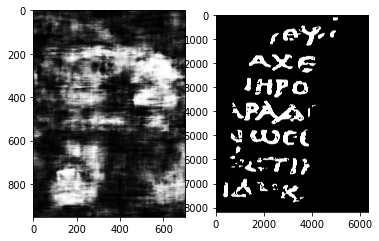

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

100%|██████████| 20833/20833 [01:00<00:00, 341.90it/s]


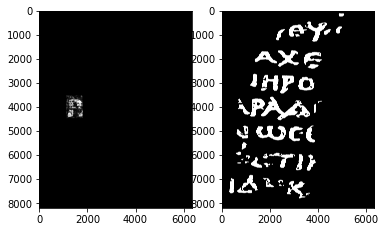

In [74]:
eval_dataset = SubvolumeDataset(image_stack, label, pixels_inside_rect)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
output = torch.zeros_like(label).float()
model.eval()
with torch.no_grad():
    for i, (subvolumes, _) in enumerate(tqdm(eval_loader)):
        for j, value in enumerate(model(subvolumes.to(device))):
            output[pixels_inside_rect[i*batch_size+j]] = value

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()


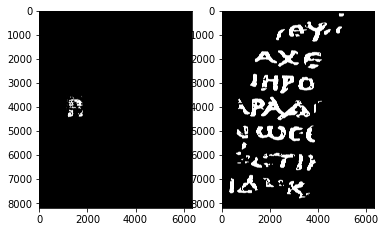

In [22]:
threshold = 0.4
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.gt(threshold).cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()